In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from umap import UMAP
from bertopic import BERTopic
import hdbscan
import re
import json

In [2]:
class ProductGroupGenerator:
    def __init__(self, min_cluster_size=5, max_clusters=75):
        self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.tfidf = TfidfVectorizer(
            max_features=1000,
            stop_words='english',
            ngram_range=(1, 2)
        )
        self.min_cluster_size = min_cluster_size
        self.max_clusters = max_clusters
        
    def preprocess_text(self, text):
        # Convert to lowercase and remove special characters
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(text).lower())
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
        
    def generate_clusters(self, texts, method='combined', n_clusters=None):
        """
        Generate product clusters using different methods
        
        Args:
            texts: List of product titles/descriptions
            method: One of 'tfidf_kmeans', 'bert_topic', or 'combined'
            n_clusters: Optional target number of clusters
        """
        if n_clusters is None:
            n_clusters = min(len(texts) // self.min_cluster_size, self.max_clusters)
            
        processed_texts = [self.preprocess_text(text) for text in texts]
        
        if method == 'tfidf_kmeans':
            return self._cluster_tfidf_kmeans(processed_texts, n_clusters)
        elif method == 'bert_topic':
            return self._cluster_bert_topic(processed_texts)
        elif method == 'combined':
            return self._cluster_combined(processed_texts, n_clusters)
        else:
            raise ValueError("Invalid clustering method")
    
    def _cluster_tfidf_kmeans(self, texts, n_clusters):
        # Transform texts to TF-IDF vectors
        tfidf_matrix = self.tfidf.fit_transform(texts)
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(tfidf_matrix)
        
        # Get top terms for each cluster
        cluster_terms = {}
        feature_names = self.tfidf.get_feature_names_out()
        for i in range(n_clusters):
            center_indices = kmeans.cluster_centers_[i].argsort()[::-1][:5]
            cluster_terms[i] = [feature_names[idx] for idx in center_indices]
            
        return labels, cluster_terms
    
    def _cluster_bert_topic(self, texts):
        # Create embeddings
        embeddings = self.sentence_model.encode(texts)
        
        # Initialize BERTopic
        topic_model = BERTopic(
            umap_model=UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine'),
            hdbscan_model=hdbscan.HDBSCAN(
                min_cluster_size=self.min_cluster_size,
                min_samples=1,
                metric='euclidean',
                cluster_selection_method='eom'
            ),
            verbose=True
        )
        
        # Fit the model and get topics
        labels, _ = topic_model.fit_transform(texts, embeddings)
        
        # Get topic terms
        topic_terms = {}
        for topic_idx, words in topic_model.get_topics().items():
            topic_terms[topic_idx] = [word[0] for word in words[:5]]
            
        return labels, topic_terms
    
    def _cluster_combined(self, texts, n_clusters):
        # Get clusters from both methods
        print("CLUSTERING BY KMEANS")
        kmeans_labels, kmeans_terms = self._cluster_tfidf_kmeans(texts, n_clusters)
        print("CLUSTERING BY BERT")
        bert_labels, bert_terms = self._cluster_bert_topic(texts)
        
        # Create ensemble clustering
        # Convert labels to one-hot encoding
        def one_hot_encode(labels):
            n_unique = len(np.unique(labels))
            return np.eye(n_unique)[labels]
        
        kmeans_oh = one_hot_encode(kmeans_labels)
        bert_oh = one_hot_encode(bert_labels)
        
        # Concatenate features
        combined_features = np.hstack([kmeans_oh, bert_oh])
        
        # Final clustering on combined features
        print("CREATING FINAL CLUSTERING COMBINATION")
        final_kmeans = KMeans(n_clusters=n_clusters)
        final_labels = final_kmeans.fit_predict(combined_features)
        
        # Combine terms from both methods for final clusters
        final_terms = {}
        for i in range(n_clusters):
            terms_set = set()
            terms_set.update(kmeans_terms.get(i, []))
            terms_set.update(bert_terms.get(i, []))
            final_terms[i] = list(terms_set)[:5]
            
        return final_labels, final_terms

    def analyze_clusters(self, texts, labels, cluster_terms):
        """
        Analyze cluster quality and characteristics
        """
        cluster_stats = {}
        unique_labels = np.unique(labels)
        
        for label in unique_labels:
            cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == label]
            cluster_stats[label] = {
                'size': len(cluster_texts),
                'terms': cluster_terms.get(label, []),
                'sample_products': cluster_texts[:3]  # Show 3 example products
            }
            
        return cluster_stats

In [3]:
# Prepare your data
products_df = pd.read_csv('data/tools_and_home_improvement_products.csv')
texts = products_df['title'] + ' ' + products_df['description']

In [4]:
# Initialize clustering class
generator = ProductGroupGenerator(min_cluster_size=100, max_clusters = 100)

In [5]:
# Run clustering
labels, cluster_terms = generator.generate_clusters(texts, method='bert_topic')

2025-02-09 14:19:57,435 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-09 14:21:00,048 - BERTopic - Dimensionality - Completed ✓
2025-02-09 14:21:00,051 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-09 14:21:02,175 - BERTopic - Cluster - Completed ✓
2025-02-09 14:21:02,189 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-09 14:21:07,544 - BERTopic - Representation - Completed ✓


In [6]:
# Analyze the clusters
cluster_stats = generator.analyze_clusters(texts, labels, cluster_terms)

In [7]:
# Number of total products
products_df.shape[0] 

16471

In [8]:
# Number of clusters
len(cluster_stats)

59

In [9]:
# Sample of group sizes and key terms
for i in range(10):
    print(f"Cluster Size: {cluster_stats[i]['size']}")
    print(f"Key Terms: {', '.join(cluster_stats[i]['terms'])}\n")

Cluster Size: 770
Key Terms: saw, blade, cutting, tool, battery

Cluster Size: 733
Key Terms: bit, set, bits, screwdriver, drill

Cluster Size: 526
Key Terms: outlet, cord, plug, extension, soldering

Cluster Size: 482
Key Terms: bulbs, bulb, light, led, incandescent

Cluster Size: 422
Key Terms: light, sensor, motion, night, closet

Cluster Size: 413
Key Terms: door, lock, doors, security, entry

Cluster Size: 413
Key Terms: strip, led, lights, music, rgb

Cluster Size: 394
Key Terms: peel, stick, wallpaper, wall, decals

Cluster Size: 376
Key Terms: tape, picture, seal, and, carpet

Cluster Size: 363
Key Terms: paint, wood, spray, brush, and



In [10]:
num_items = []

for cluster in cluster_stats.keys():
    num_items.append(cluster_stats[cluster]['size'])

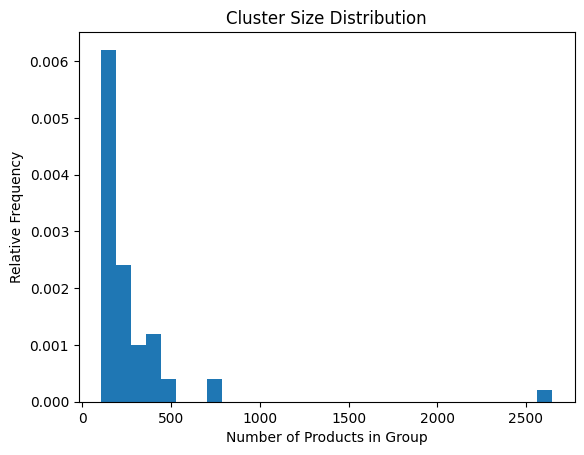

In [11]:
plt.hist(num_items, bins=30, density=True)
plt.title("Cluster Size Distribution")
plt.xlabel("Number of Products in Group")
plt.ylabel("Relative Frequency")
plt.show()

In [12]:
products_df['label'] = labels
products_df['label'].value_counts()[:5]

label
-1    2648
 0     770
 1     733
 2     526
 3     482
Name: count, dtype: int64

In [13]:
for i in range(len(cluster_stats)-1):
    print(cluster_stats[i]['terms'])

['saw', 'blade', 'cutting', 'tool', 'battery']
['bit', 'set', 'bits', 'screwdriver', 'drill']
['outlet', 'cord', 'plug', 'extension', 'soldering']
['bulbs', 'bulb', 'light', 'led', 'incandescent']
['light', 'sensor', 'motion', 'night', 'closet']
['door', 'lock', 'doors', 'security', 'entry']
['strip', 'led', 'lights', 'music', 'rgb']
['peel', 'stick', 'wallpaper', 'wall', 'decals']
['tape', 'picture', 'seal', 'and', 'carpet']
['paint', 'wood', 'spray', 'brush', 'and']
['shower', 'head', 'water', 'pressure', 'handheld']
['flashlight', 'rechargeable', 'lumens', 'light', 'led']
['solar', 'lights', 'garden', 'outdoor', 'pathway']
['lamp', 'table', 'bedside', 'lamps', 'usb']
['mask', 'face', 'masks', 'kn95', 'nose']
['knife', 'blade', 'multitool', 'pocket', 'blades']
['ceiling', 'light', 'fixture', 'vanity', 'mirror']
['furniture', 'chair', 'pads', 'leg', 'felt']
['klein', 'tools', 'wire', 'tool', 'company']
['reading', 'desk', 'lamp', 'light', 'book']
['faucet', 'kitchen', 'faucets', 'sink

In [14]:
cluster_terms = {i: cluster_stats[i]['terms'] for i in range(-1, len(cluster_stats)-1)}

In [20]:
with open("tools_and_home_improvement_key_terms.json", "w") as f:
    json.dump(cluster_terms, f)

In [21]:
products_df.head()

,id,title,description,label
0,B09M8J9LQ9,Decute 200LED Christmas String Lights Outdoor ...,Specifications Light Color Multicolored Applic...,22
1,B0BNZ888C7,Upgrade Hydro Shower Jet Head High Pressure Hy...,HighPressure Filtered Shower Head with 3 Repla...,10
2,B07TLCQ3NR,"1"" Adhesive Furniture Sliders -Furnigear Chair...",Adhesive Furniture Glides SlidersFurnigear Hea...,17
3,B09HRSKRFB,"Sunlite 40455 LED A19 Colored Light Bulb, 3 Wa...",Sunlites colored decorative A19 household ligh...,3
4,B014AV8FY2,Dixie Belle Paint Company Chalk Finish Furnitu...,CHALK MINERAL PAINT Amethyst is a rich deep m...,9


In [22]:
products_df.to_csv("data/labeled_tools_and_home_improvement_products.csv", index=False)